In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import os
import warnings
import requests
import branca
import folium
import json

from matplotlib import pyplot as plt
import matplotlib.lines as lines
from matplotlib.colors import LinearSegmentedColormap
from folium import plugins
from folium.plugins import Search
from folium.plugins import HeatMap


dir_atual = os.path.dirname(os.path.abspath('__file__'))
root_dir = os.path.abspath(os.path.join(dir_atual, '..'))
input_path = os.path.join(dir_atual, 'input')
formas_paises_url = 'https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/world-countries.json'


warnings.filterwarnings('ignore')

sns.set()

%matplotlib inline

In [2]:

dados = pd.read_csv(os.path.join(input_path, 'athlete_events.csv'))
regioes = pd.read_csv(os.path.join(input_path, 'noc_regions.csv'))

In [3]:
mesclado = pd.merge(dados, regioes, on='NOC', how='left')
mesclado.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN,China,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN,China,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN,Denmark,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark,NaN
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN,Netherlands,NaN


In [196]:
# Função para formatar os valores
def formata_valor(valor):
    if valor < 1_000:
        return f"{valor}"
    elif valor < 1_000_000:
        return f"{valor / 1_000:.1f} K"
    else:
        return f"{valor / 1_000_000:.1f} M"

In [119]:
# Filtrando as competições por inverno e verão
comp_verao = mesclado[mesclado['Season']=='Summer']   
comp_inverno = mesclado[mesclado['Season']=='Winter']

# Quantidade de competições
num_comp_verao = comp_verao['Year'].nunique()           
num_comp_inverno = comp_inverno['Year'].nunique() 

# Quantidade de medalhas
num_medalhas_verao = comp_verao[comp_verao['Medal'] != 'NA']['Medal'].value_counts().sum()
num_medalhas_inverno = comp_inverno[comp_inverno['Medal'] != 'NA']['Medal'].value_counts().sum()

# Média de medalhas por competição
media_medalha_comp_verao = (num_medalhas_verao)/(num_comp_verao)
media_medalha_comp_inverno = (num_medalhas_inverno)/(num_comp_inverno)

texto_explicativo= f"""
Nos últimos 120 anos 
de comptição 
tivemos {num_comp_verao} competições
de verão e {num_comp_inverno} 
competições de inverno.\n
Foram distribuidas 
{num_medalhas_verao + num_medalhas_inverno} medalhas,
sendo {num_medalhas_verao} nas competições
de verão e {num_medalhas_inverno} 
nas competições de inverno.

Na média,
são distribuidas {media_medalha_comp_verao:.0f} 
medalhas por competição 
no verão e {media_medalha_comp_inverno:.0f} medalhas 
por competição no inverno"""



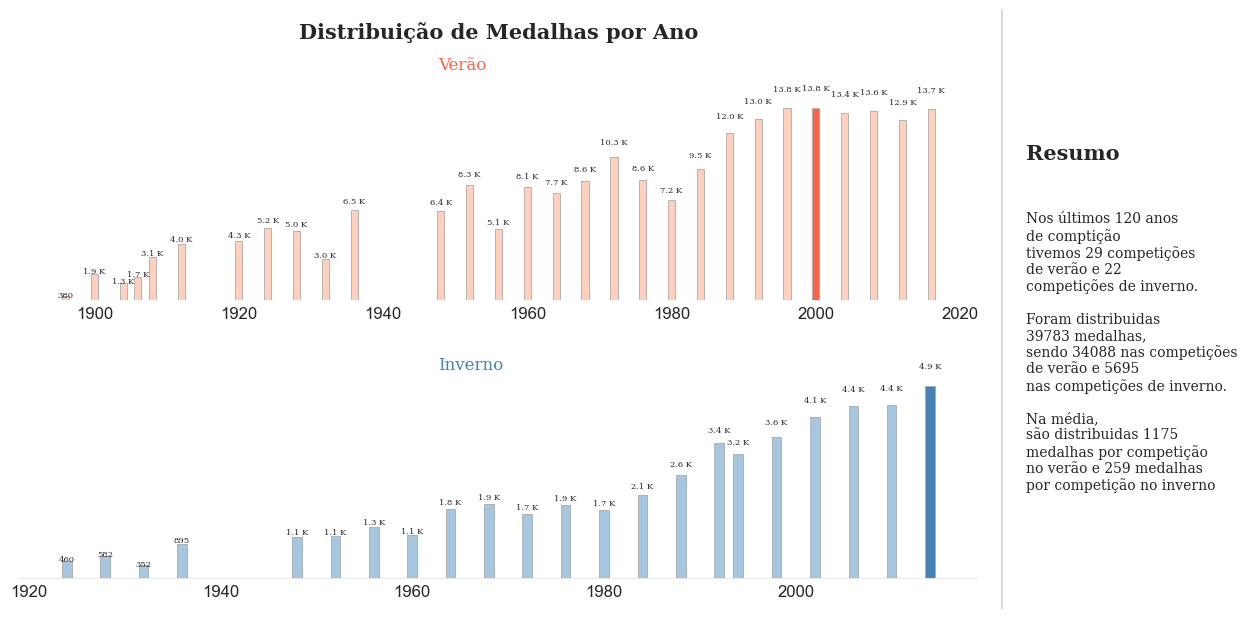

In [201]:
medalhas_ano_verao = comp_verao.groupby(['Year'])['Year'].value_counts().reset_index()
medalhas_ano_verao.set_index('Year', inplace=True)

medalhas_ano_inverno = comp_inverno.groupby(['Year'])['Year'].value_counts().reset_index()
medalhas_ano_inverno.set_index('Year', inplace=True)

medalhas_ano_verao = medalhas_ano_verao.sort_index()
medalhas_ano_inverno = medalhas_ano_inverno.sort_index()

max_verao = medalhas_ano_verao['count'].max()
max_inverno = medalhas_ano_inverno['count'].max()

# Preparar os mapas de cores
color_map_verao = ['#FED0BD' if count != max_verao else '#FF6347' for count in medalhas_ano_verao['count']]
color_map_inverno = ['#A7C6DF' if count != max_inverno else '#4682B4' for count in medalhas_ano_inverno['count']]

fig, (ax, ax2) = plt.subplots(2, 1, figsize=(12, 6))
ax.bar(x=medalhas_ano_verao.index, height=medalhas_ano_verao['count'],width=1, 
       edgecolor='darkgray',
       linewidth=0.6, color=color_map_verao
       )

for i in medalhas_ano_verao.index:
    ax.annotate(f"{formata_valor(medalhas_ano_verao.at[i, 'count'])}", 
                xy=(i, medalhas_ano_verao.at[i, 'count']*1.1),
                va='center', ha='center', fontweight='light', fontfamily='serif', fontsize=6)
    

for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)

ax.grid(axis='y', linestyle='-', alpha=0.4)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_yticklabels([])
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.set_ylim(0, max_verao * 1.2)
ax.set_facecolor('white')
ax


ax2.bar(x=medalhas_ano_inverno.index, height=medalhas_ano_inverno['count'],width=1, 
       edgecolor='darkgray',
       linewidth=0.6, color=color_map_inverno
       )

for i in medalhas_ano_inverno.index:
    ax2.annotate(f"{formata_valor(medalhas_ano_inverno.at[i, 'count'])}", 
                xy=(i, medalhas_ano_inverno.at[i, 'count']*1.1),
                va='center', ha='center', fontweight='light', fontfamily='serif', fontsize=6)


ax2.grid(axis='y', linestyle='-', alpha=0.4)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_yticklabels([])
ax2.tick_params(axis=u'both', which=u'both',length=0)
ax2.set_ylim(0, max_inverno * 1.2)
ax2.set_facecolor('white')

plt.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)

fig.suptitle('Distribuição de Medalhas por Ano', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.45, 0.9, 'Verão', fontsize=12, fontweight='light', fontfamily='serif', color='#FF6347')
fig.text(0.45, 0.4, 'Inverno', fontsize=12, fontweight='light', fontfamily='serif', color='#4682B4')

l1 = lines.Line2D([0.92, 0.92], [0, 1], transform=fig.transFigure, figure=fig,color='black',lw=0.2)
fig.lines.extend([l1])

fig.text(0.94, 0.75, 'Resumo', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.94, 0.2, texto_explicativo, fontsize=10, fontweight='light', fontfamily='serif',ha='left')

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.05)



In [181]:
ordenar_valores_verao = medalhas_ano_verao.sort_values(by='count', ascending=False).reset_index()
ordenar_valores_verao

,Year,count
0,2000,13821
1,1996,13780
2,2016,13688
3,2008,13602
4,2004,13443
5,1992,12977
6,2012,12920
7,1988,12037
8,1972,10304
9,1984,9454
